In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statistics
from scipy.stats import mannwhitneyu
from bs4 import BeautifulSoup  
import requests
import string
import pymorphy2
import dask.bag as db
from datetime import datetime
from sklearn.model_selection import train_test_split

# Задача: построить модель количество визитов в больницу
### Загружаем данные

In [4]:
item = 'OFP' # Выбрать из поля Item для вашего датасета
package = 'Ecdat' # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package , cache=True).data
df.head()

,ofp,ofnp,opp,opnp,emr,hosp,numchron,adldiff,age,black,sex,maried,school,faminc,employed,privins,medicaid,region,hlth
0,5,0,0,0,0,1,2,0,6.9,yes,male,yes,6,2.8810,yes,yes,no,other,other
1,1,0,2,0,2,0,2,0,7.4,no,female,yes,10,2.7478,no,yes,no,other,other
2,13,0,0,0,3,3,4,1,6.6,yes,female,no,10,0.6532,no,no,yes,other,poor
3,16,0,5,0,1,1,2,1,7.6,no,male,yes,3,0.6588,no,yes,no,other,poor
4,3,0,0,0,0,0,2,1,7.9,no,female,yes,6,0.6588,no,yes,no,other,other


### Вводим новую переменную количество визитов в больницу

In [7]:
df['hosp_v'] = df['ofp'] + df['opp'] + df['opnp'] + df['ofnp'] + df['emr'] + df['hosp']

### Приводим возраст в надлежащий вид (в датасете они разделены на 10)

In [10]:
df['age'] = df['age']*10
df['age'] = df['age'].round().astype(int)

### Просмотрим структуру нашего df и определим есть ли пропуски

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4406 entries, 0 to 4405
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ofp       4406 non-null   int64  
 1   ofnp      4406 non-null   int64  
 2   opp       4406 non-null   int64  
 3   opnp      4406 non-null   int64  
 4   emr       4406 non-null   int64  
 5   hosp      4406 non-null   int64  
 6   numchron  4406 non-null   int64  
 7   adldiff   4406 non-null   int64  
 8   age       4406 non-null   int32  
 9   black     4406 non-null   object 
 10  sex       4406 non-null   object 
 11  maried    4406 non-null   object 
 12  school    4406 non-null   int64  
 13  faminc    4406 non-null   float64
 14  employed  4406 non-null   object 
 15  privins   4406 non-null   object 
 16  medicaid  4406 non-null   object 
 17  region    4406 non-null   object 
 18  hlth      4406 non-null   object 
 19  hosp_v    4406 non-null   int64  
dtypes: float64(1), int32(1), int64

In [15]:
# Пропусков нет.

### Заменяем категориальные переменные 0 и 1

In [18]:
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)
df['black'] = df['black'].apply(lambda x: 1 if x == 'yes' else 0)
df['maried'] = df['maried'].apply(lambda x: 1 if x == 'yes' else 0)
df['employed'] = df['employed'].apply(lambda x: 1 if x == 'yes' else 0)
df['privins'] = df['privins'].apply(lambda x: 1 if x == 'yes' else 0)
df['medicaid'] = df['medicaid'].apply(lambda x: 1 if x == 'yes' else 0)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4406 entries, 0 to 4405
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ofp       4406 non-null   int64  
 1   ofnp      4406 non-null   int64  
 2   opp       4406 non-null   int64  
 3   opnp      4406 non-null   int64  
 4   emr       4406 non-null   int64  
 5   hosp      4406 non-null   int64  
 6   numchron  4406 non-null   int64  
 7   adldiff   4406 non-null   int64  
 8   age       4406 non-null   int32  
 9   black     4406 non-null   int64  
 10  sex       4406 non-null   int64  
 11  maried    4406 non-null   int64  
 12  school    4406 non-null   int64  
 13  faminc    4406 non-null   float64
 14  employed  4406 non-null   int64  
 15  privins   4406 non-null   int64  
 16  medicaid  4406 non-null   int64  
 17  region    4406 non-null   object 
 18  hlth      4406 non-null   object 
 19  hosp_v    4406 non-null   int64  
dtypes: float64(1), int32(1), int64

In [22]:
df

,ofp,ofnp,opp,opnp,emr,hosp,numchron,adldiff,age,black,sex,maried,school,faminc,employed,privins,medicaid,region,hlth,hosp_v
0,5,0,0,0,0,1,2,0,69,1,1,1,6,2.881000,1,1,0,other,other,6
1,1,0,2,0,2,0,2,0,74,0,0,1,10,2.747800,0,1,0,other,other,5
2,13,0,0,0,3,3,4,1,66,1,0,0,10,0.653200,0,0,1,other,poor,19
3,16,0,5,0,1,1,2,1,76,0,1,1,3,0.658800,0,1,0,other,poor,23
4,3,0,0,0,0,0,2,1,79,0,0,1,6,0.658800,0,1,0,other,other,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4401,11,0,0,0,0,0,0,0,84,0,0,1,8,2.249700,0,1,0,other,other,11
4402,12,0,0,0,0,0,2,0,78,0,0,0,11,5.813200,0,1,0,other,other,12
4403,10,0,20,0,1,1,5,0,73,0,1,1,12,3.877916,0,1,0,other,other,32
4404,16,1,0,0,0,0,0,0,66,0,0,1,12,3.877916,0,1,0,other,other,17


In [24]:
cat_hos = ['employed', 'privins', 'maried']
num_hos = ['numchron','school', 'faminc', 'age']
target_hos = ['hosp_v']

### Посмотрим на распределение целевой переменной

array([[<Axes: title={'center': 'hosp_v'}>]], dtype=object)

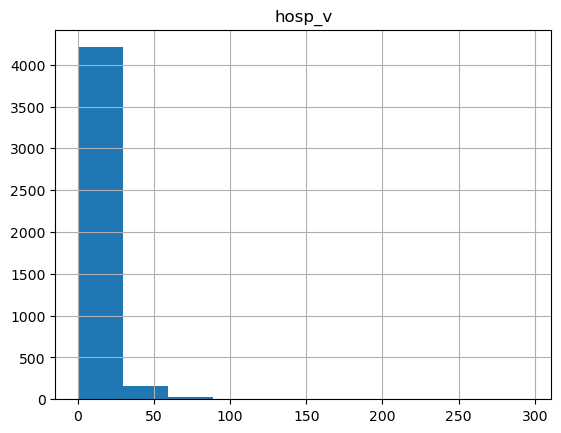

In [27]:
df[target_hos].hist()

### Обучим модель без учета выбросов

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[cat_hos + num_hos], df[target_hos], test_size = 0.4, random_state = 42)

In [32]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

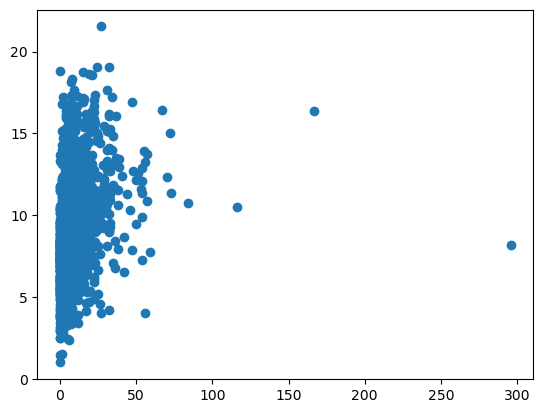

In [34]:
y_pred = ols.predict(X_test)
plt.scatter(y_test, y_pred)
plt.show()

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('R2', r2_score(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred))

R2 0.06253782321654211
MAE 6.67855952328034
RMSE 12.250690313721828
MAPE 3186710008193078.5


### Убираем выбросы

In [39]:
df['hosp_v'].describe()

count    4406.000000
mean        9.238765
std        12.198796
min         0.000000
25%         2.000000
50%         6.000000
75%        12.000000
max       296.000000
Name: hosp_v, dtype: float64

In [41]:
q1 = df['hosp_v'].quantile(0.25)
q3 = df['hosp_v'].quantile(0.75)
iqr = q3 - q1
df = df[(df['hosp_v']>=q1 - 1.5*iqr)&(df['hosp_v']<=q1 + 1.5*iqr)]

In [43]:
df['hosp_v'].describe()

count    3821.000000
mean        5.909710
std         4.611784
min         0.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        17.000000
Name: hosp_v, dtype: float64

array([[<Axes: title={'center': 'hosp_v'}>]], dtype=object)

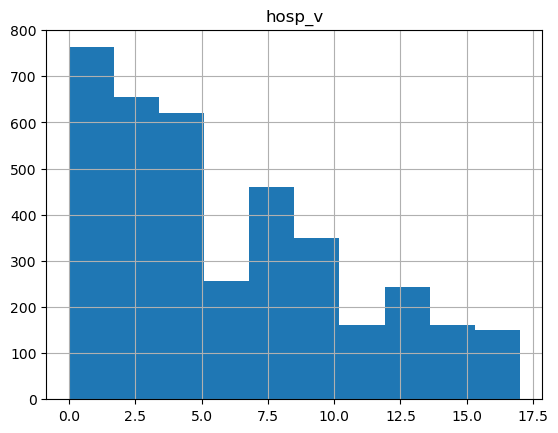

In [45]:
df[target_hos].hist()

### Обучаем задачу классификации

In [48]:
y_clf = np.where(df[target_hos] == 0, 0, 1)
X_clf = df[num_hos + cat_hos]

### Делим выборку на обучающую, тестовую и прогнозную

In [51]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size = 0.4, random_state = 42)

#### Обучим модель логистической регрессии

In [54]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(random_state=0).fit(X_train_clf, y_train_clf)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
y_pred_clf = logit.predict(X_test_clf)

In [58]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test_clf, y_pred_clf), index = ['True 0', 'True 1'], columns = ['Pred 0', 'Pred 1'])

,Pred 0,Pred 1
True 0,0,174
True 1,0,1355


In [60]:
from sklearn.metrics import precision_score, recall_score
print('Precision', precision_score(y_test_clf, y_pred_clf))
print('Recall', recall_score(y_test_clf, y_pred_clf))

Precision 0.8862001308044474
Recall 1.0


### Обучаем задачу регрессии

#### Оставляем в выборке только те посещения, где есть ненулевые

In [64]:
data_nonnull = df[df['hosp_v']>0]

#### Linear Regression (OLS)

In [67]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(data_nonnull[cat_hos + num_hos], data_nonnull[target_hos], test_size = 0.4, random_state = 42)

In [69]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train_reg, y_train_reg)

LinearRegression()

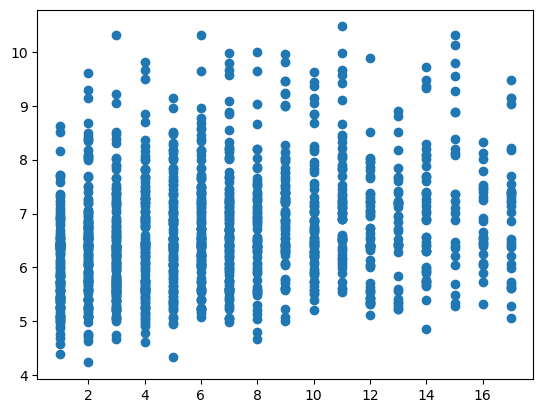

In [71]:
y_pred_reg = ols.predict(X_test_reg)
plt.scatter(y_test_reg, y_pred_reg)
plt.show()

### Метрики качества модели регрессии

In [74]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('R2', r2_score(y_test_reg, y_pred_reg))
print('MAE', mean_absolute_error(y_test_reg, y_pred_reg))
print('RMSE', np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print('MAPE', mean_absolute_percentage_error(y_test_reg, y_pred_reg))

R2 0.06146330582863124
MAE 3.46340415766485
RMSE 4.220099240813193
MAPE 1.0430193780976034


### Оценим качество ансамбля моделей

1) Возьмем тестовую выборку задачи классификации

2) Для этой выборки сделаем предсказание, будет или нет походов в больницу

3) Для тех строк, в которых будут посищения, сделаем предсказание количества их с помощью модели регрессии

4) Оценим качество модели в совокупности

In [78]:
test_obs = X_test_clf.index

In [80]:
test_df = df.loc[test_obs, cat_hos + num_hos + target_hos]
test_df.head()

,employed,privins,maried,numchron,school,faminc,age,hosp_v
3179,0,1,1,3,8,4.5720,67,2
1652,0,1,0,0,0,0.9810,75,0
2518,0,1,1,0,5,1.4932,85,4
4047,0,1,1,2,10,2.0014,72,10
3520,0,1,0,2,12,0.6324,75,7


In [82]:
test_df['is_hosp_pred'] = y_test_clf
test_df.head()

,employed,privins,maried,numchron,school,faminc,age,hosp_v,is_hosp_pred
3179,0,1,1,3,8,4.5720,67,2,1
1652,0,1,0,0,0,0.9810,75,0,0
2518,0,1,1,0,5,1.4932,85,4,1
4047,0,1,1,2,10,2.0014,72,10,1
3520,0,1,0,2,12,0.6324,75,7,1


In [84]:
X_test_clf_reg = test_df.loc[test_df['is_hosp_pred']==1, cat_hos + num_hos]
y_pred_clf_reg = ols.predict(X_test_clf_reg)

In [86]:
test_df.loc[test_df['is_hosp_pred']==1,'pred_hosp'] = y_pred_clf_reg
test_df['pred_hosp'] = test_df['pred_hosp'].fillna(0)
test_df 

,employed,privins,maried,numchron,school,faminc,age,hosp_v,is_hosp_pred,pred_hosp
3179,0,1,1,3,8,4.5720,67,2,1,7.743925
1652,0,1,0,0,0,0.9810,75,0,0,0.000000
2518,0,1,1,0,5,1.4932,85,4,1,4.957985
4047,0,1,1,2,10,2.0014,72,10,1,7.047370
3520,0,1,0,2,12,0.6324,75,7,1,7.354067
...,...,...,...,...,...,...,...,...,...,...
4256,0,1,0,1,11,0.3720,76,11,1,6.449724
2784,0,0,0,3,5,0.3444,76,12,1,7.255081
1688,0,0,1,0,8,13.4931,67,0,0,0.000000
2235,0,1,1,5,18,2.0801,68,11,1,10.162927


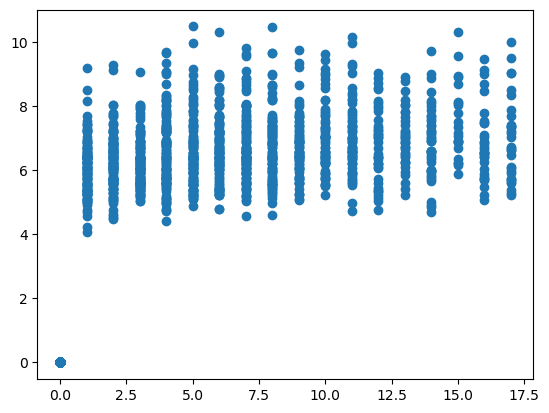

In [88]:
plt.scatter(test_df['hosp_v'], test_df['pred_hosp'])
plt.show()

In [90]:
print('R2', r2_score(test_df['hosp_v'], test_df['pred_hosp']))
print('MAE', mean_absolute_error(test_df['hosp_v'], test_df['pred_hosp']))
print('RMSE', np.sqrt(mean_squared_error(test_df['hosp_v'], test_df['pred_hosp'])))
print('MAPE', mean_absolute_percentage_error(test_df['hosp_v'], test_df['pred_hosp']))

R2 0.2661916047741023
MAE 3.0180352549847287
RMSE 3.9314786273605127
MAPE 0.8996797606617885


# Кластеризация

Кластеризация - это поиск скрытых закономерностей или схожестей между объектами наблюдения в данных на основе собранных переменных

In [94]:
df.head()

,ofp,ofnp,opp,opnp,emr,hosp,numchron,adldiff,age,black,sex,maried,school,faminc,employed,privins,medicaid,region,hlth,hosp_v
0,5,0,0,0,0,1,2,0,69,1,1,1,6,2.8810,1,1,0,other,other,6
1,1,0,2,0,2,0,2,0,74,0,0,1,10,2.7478,0,1,0,other,other,5
4,3,0,0,0,0,0,2,1,79,0,0,1,6,0.6588,0,1,0,other,other,3
5,17,0,0,0,0,0,5,1,66,0,0,0,7,0.3301,0,0,1,other,poor,17
6,9,0,0,0,0,0,0,0,75,0,0,0,8,0.8280,0,1,0,midwest,other,9


In [96]:
len(df['school'].unique())

19

Основная идея кластеризации разделить все наблюдения на несколько групп так, чтобы внутри группы наблюдения были максимально схожи, а группы при этом максимально отличались друг от друга

#### Проведем кластеризацию по двум признакам

In [100]:
X = df[['hosp_v', 'school']]

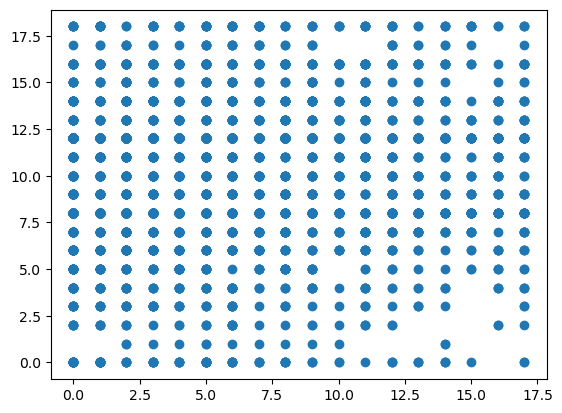

In [102]:
plt.scatter(X['hosp_v'], X['school'])

#### Нормализуем переменные

In [105]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler =  MinMaxScaler().fit(X)  # fit does nothing
X_norm = minmaxscaler.transform(X)

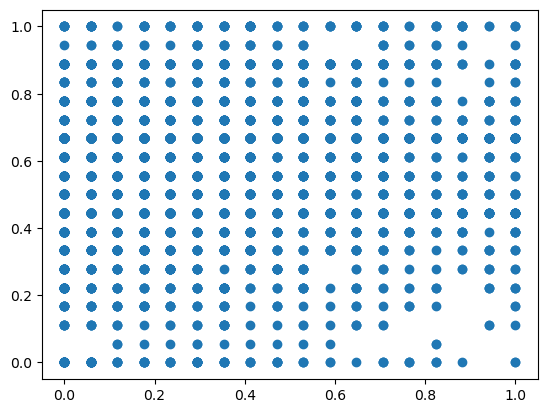

In [107]:
plt.scatter(X_norm[:,0], X_norm[:,1])

#### Для кластеризации применим метод K-means

In [110]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_norm)

In [112]:
X['cluster_2'] = kmeans.labels_

C:\Users\e.sytnik\AppData\Local\Temp\ipykernel_9912\3425817590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster_2'] = kmeans.labels_


In [114]:
X

,hosp_v,school,cluster_2
0,6,6,0
1,5,10,0
4,3,6,0
5,17,7,1
6,9,8,1
...,...,...,...
4400,17,7,1
4401,11,8,1
4402,12,11,1
4404,17,12,1


<Axes: xlabel='hosp_v', ylabel='school'>

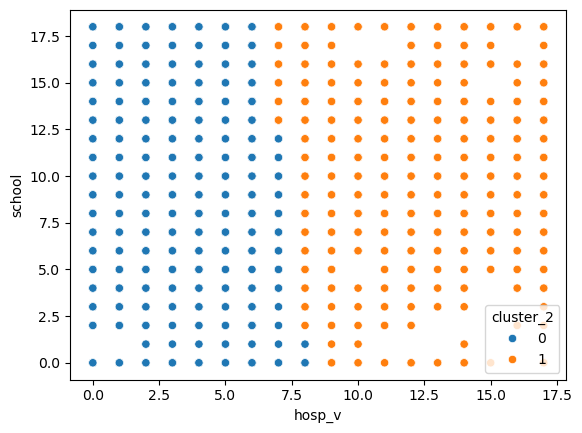

In [116]:
sns.scatterplot(x = 'hosp_v', y = 'school', hue = 'cluster_2', data = X)

#### Попробуем разделить на 4 кластера

In [119]:
kmeans = KMeans(n_clusters = 4, random_state=0, n_init="auto").fit(X_norm)

In [121]:
X['cluster_4'] = kmeans.labels_

C:\Users\e.sytnik\AppData\Local\Temp\ipykernel_9912\2612241038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster_4'] = kmeans.labels_


<Axes: xlabel='hosp_v', ylabel='school'>

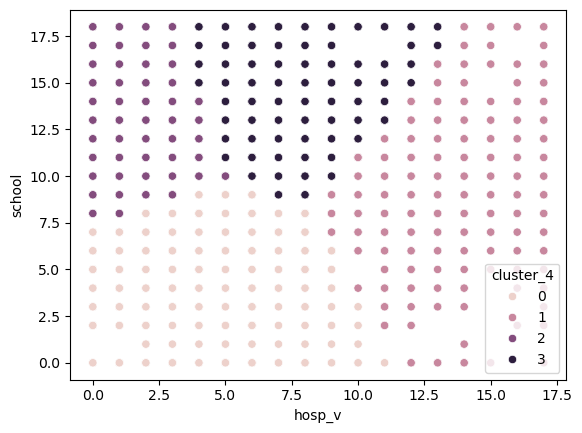

In [123]:
sns.scatterplot(x = 'hosp_v', y = 'school', hue = 'cluster_4', data = X)

Text(0.5, 1.0, 'Elbow curve')

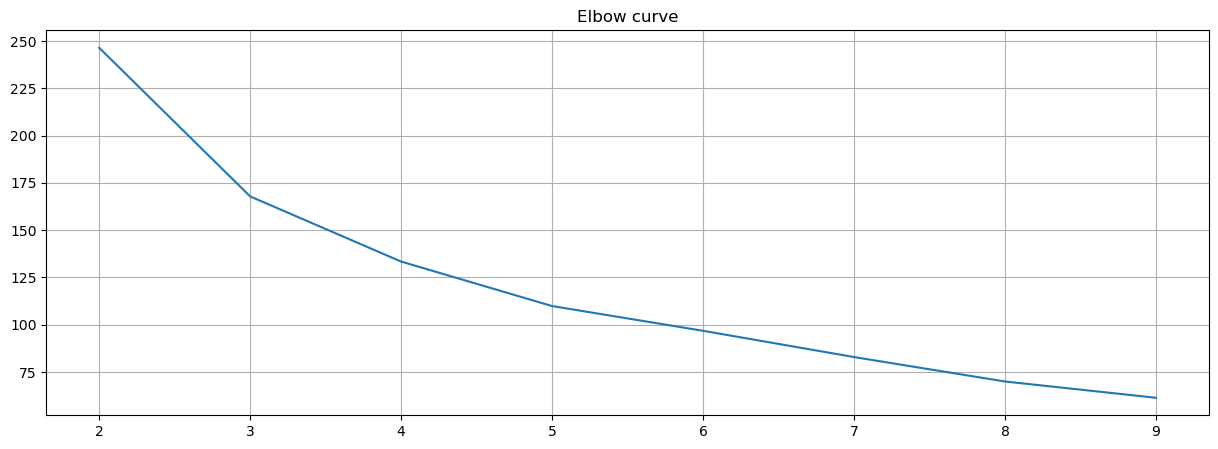

In [125]:
distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_norm)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

##### На основе метода локтя можем сказать, что наилучшим количеством кластеров является 5

### Проведем кластеризацию, используя переменные, доступные в данных

In [129]:
minmaxscaler =  MinMaxScaler().fit(df[num_hos + target_hos])  
X_norm = minmaxscaler.transform(df[num_hos + target_hos])

Text(0.5, 1.0, 'Elbow curve')

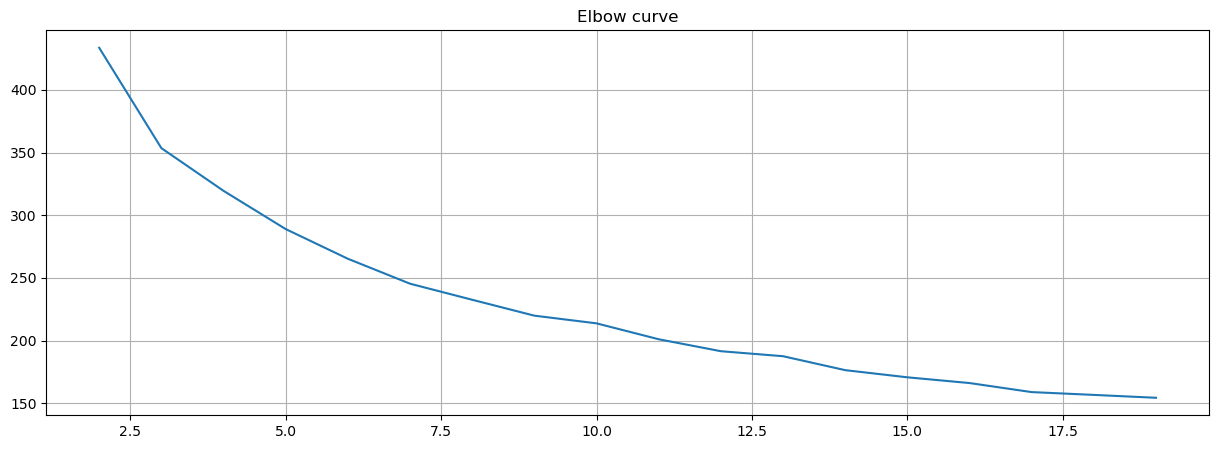

In [131]:
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_norm)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

Выбирая между интерпретируемостью и точностью разделения, примем 10 кластеров за оптимальное число

In [133]:
kmeans = KMeans(n_clusters = 10, random_state=0, n_init="auto").fit(X_norm)
df['cluster'] = kmeans.labels_

C:\Users\e.sytnik\AppData\Local\Temp\ipykernel_9912\831567622.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.labels_


In [135]:
df.groupby('cluster')[num_hos+target_hos].mean()

,numchron,school,faminc,age,hosp_v
cluster,,,,,
0,3.234286,10.180000,2.013467,73.737143,4.391429
1,1.357639,15.812500,4.944299,73.930556,5.850694
2,1.265060,13.382530,3.125932,72.858434,13.259036
3,1.693333,6.710000,1.857948,76.296667,12.933333
4,0.621145,12.405286,2.945860,70.945668,1.578561
5,0.713402,6.715464,1.967326,71.381443,1.511340
6,1.916667,2.717593,1.498070,79.120370,4.939815
7,0.993884,9.562691,1.957644,84.688073,3.055046
8,3.973451,10.752212,2.374611,74.845133,11.712389


<Axes: xlabel='hosp_v', ylabel='school'>

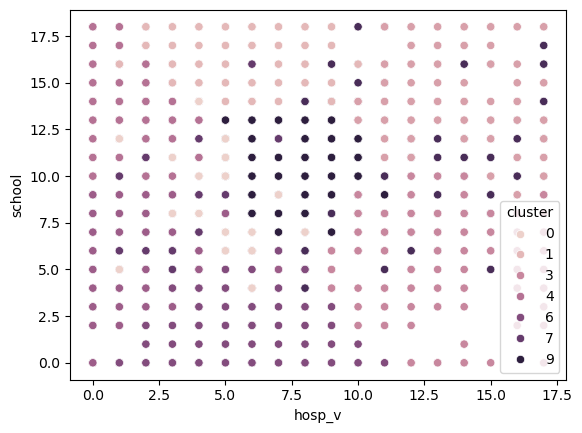

In [137]:
sns.scatterplot(x = 'hosp_v', y = 'school', hue = 'cluster', data = df)

На базе сравнения средних величин по переменным можно каждому кластеру дать содержательную интерпретацию

Кластер 5 включает строки с самим минимальным количеством посещений больницы и с самым маленьким количеством заболеваний

Кластер 2 - это люди с самым высоким количеством посещений больницы и практически с высоким обумением

### Таким образом можно сделать вывод, что люди с самым маленьким количеством хронических заболеваний попадают реже в больницу.